In [2]:
# ESSENTIAL
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sqlite3
import random
import os
import logging
from datetime import datetime
from itertools import combinations
from tqdm import tnrange, tqdm_notebook

# PORTFOLIO
import six
import tools
from algo import Algo
from cvxopt import solvers, matrix
solvers.options['show_progress'] = False

# ML
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# CUSTOM
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from wrappers import bitfinex as bfx
from wrappers import technical_analysis as ta

%matplotlib inline

/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [56]:
def get_trade_history_from_date(cp, _from):
    
    # connect to db
    conn = sqlite3.connect('../db/crypto.db')
    
    # get trade history per currency pair and date specified
    get_data_query = '''
    
    SELECT date, currency_pair, rate, amount
    FROM trade_history
    WHERE currency_pair="%s"
    AND date >= %s;
    
    ''' % (cp, _from)
    
    # read into df and close connection
    df = pd.read_sql(get_data_query, conn)
    conn.close()
    
    return df

# parse out performance summary from portfolio object
def olps_stats(df):
    
    for name, r in df.results.iteritems():
        df.ix[name,'profit'] = r.profit_factor
        df.ix[name,'sharpe'] = r.sharpe
        df.ix[name,'information'] = r.information
        df.ix[name,'annualized_return'] = r.annualized_return * 100
        df.ix[name,'drawdown_period'] = r.drawdown_period
        df.ix[name,'winning_pct'] = r.winning_pct * 100
    
    return df

# run trading simulation with current online portfolio optim algo
def trading_simulation(price_df, init_capital, train_window, trading_fee = 0.0, progress_print = 25):

    wealth_history = []
    capital = int(init_capital)
    counter = 0

    for i in range(train_window, price_df.shape[0]+1):

        try:
        
            # set the price df and date for the current period
            current_prices = price_df.iloc[:i,:]
            current_period = current_prices.index[-1]

            # run portfolio optim algo on current 
            algo = ONS()
            algo = algo.run(current_prices)

            # get asset weights
            current_weights = algo.weights

            # if it is the first time, get n_assets by init wealth. otherwise, first calculate new wealth
            if counter == 0:
                asset_allocation = current_weights.loc[current_period] * capital
                n_assets_owned = asset_allocation / current_prices.loc[current_period]
            
            # otherwise, balance portfolio while accounting for trading costs
            else:
                capital = (n_assets_owned * current_prices.loc[current_period]).sum()
                new_asset_allocation = current_weights.loc[current_period] * capital
                trading_fee_per_asset = abs(asset_allocation - new_asset_allocation) * trading_fee
                asset_allocation = new_asset_allocation - trading_fee_per_asset
                n_assets_owned = asset_allocation / current_prices.loc[current_period]

            # save history and print progress
            if capital <= 0: break
            wealth_history.append(capital)
            counter += 1
            if counter % progress_print == 0:
                print('Date:', current_period)
                print('Capital:', capital)
                print()

        except: return wealth_history

    #print('Success!')
    return wealth_history

# helpert to calculate sharpe from trended portfolio value / performance
def sharpe_from_performance(trended_portfolio_value, risk_free = 0):
    
    # add to an array and calculate returns
    performance = np.array(trended_portfolio_value)
    returns = performance[1:] / performance[:-1]
    
    # calc sharpe
    volatility = returns.std() * np.sqrt(len(returns))
    sharpe_ratio = (returns.mean() - risk_free) / volatility
    
    return sharpe_ratio

def max_drawdown(trended_performance):
    
    # only compare each point to the previous running peak
    trended_performance = pd.Series(trended_performance).copy()
    running_max = pd.expanding_max(trended_performance)
    cur_dd = trended_performance - running_max
    dd = min(0, cur_dd.min())
    
    return abs(dd / trended_performance.max())

# print performance summary
def performance_summary(performance):
    
    # KPIs
    return_ = performance[-1] / performance[0]
    sharpe_ = sharpe_from_performance(performance)
    mdd_ = max_drawdown(performance)
    
    return return_, sharpe_, mdd_

In [4]:
class ONS(Algo):
    """
    Online newton step algorithm.

    Reference:
        A.Agarwal, E.Hazan, S.Kale, R.E.Schapire.
        Algorithms for Portfolio Management based on the Newton Method, 2006.
        http://machinelearning.wustl.edu/mlpapers/paper_files/icml2006_AgarwalHKS06.pdf
    """

    REPLACE_MISSING = True

    def __init__(self, delta=0.125, beta=1., eta=0.):
        """
        :param delta, beta, eta: Model parameters. See paper.
        """
        super(ONS, self).__init__()
        self.delta = delta
        self.beta = beta
        self.eta = eta


    def init_weights(self, m):
        return np.ones(m) / m


    def init_step(self, X):
        m = X.shape[1]
        self.A = np.mat(np.eye(m))
        self.b = np.mat(np.zeros(m)).T


    def step(self, r, p):
        # calculate gradient
        grad = np.mat(r / np.dot(p, r)).T
        # update A
        self.A += grad * grad.T
        # update b
        self.b += (1 + 1./self.beta) * grad

        # projection of p induced by norm A
        pp = self.projection_in_norm(self.delta * self.A.I * self.b, self.A)
        return pp * (1 - self.eta) + np.ones(len(r)) / float(len(r)) * self.eta

    def projection_in_norm(self, x, M):
        """ Projection of x to simplex indiced by matrix M. Uses quadratic programming.
        """
        m = M.shape[0]

        P = matrix(2*M)
        q = matrix(-2 * M * x)
        G = matrix(-np.eye(m))
        h = matrix(np.zeros((m,1)))
        A = matrix(np.ones((1,m)))
        b = matrix(1.)

        sol = solvers.qp(P, q, G, h, A, b)
        return np.squeeze(sol['x'])

In [4]:
# this is the current list of all currency pairs in the db (and basically, all that's currenly on bfx (2017/20/01))
all_currency_pairs = [
    
    'USDT_BTC', 'USDT_BCH', 'USDT_LTC',
    'USDT_ETH', 'USDT_ETC', 'USDT_ZEC',
    'USDT_XMR', 'USDT_DASH', 'USDT_SAN',
    'USDT_NEO', 'USDT_IOTA', 'USDT_OMG',
    'USDT_QTUM', 'USDT_BTG', 'USDT_XRP',
    'USDT_GNT', 'USDT_BAT', 'USDT_ZRX',
    'USDT_FUN', 'USDT_EDO', 'USDT_AVT',
    'USDT_SNT', 'USDT_QASH', 'USDT_SPANK',
    'USDT_EOS'
    
]

In [7]:
# IMPORT BACKUP
df = pd.read_csv('portfolio_export_all_indicators_24H.csv')
df.index = pd.to_datetime(df['date'])
df = df.drop('date', 1)

# filter down to just close and currency pair
df = df[['close', 'currency_pair']]

# check what the earliest date i have data for, for each pair
#df['date'] = df.index
#df.groupby('currency_pair').min().sort_values('date', ascending = False).date

In [146]:
# # with enough data
# currency_pairs = [
    
#     'USDT_BTG', 'USDT_EDO', 'USDT_QTUM',
#     'USDT_AVT', 'USDT_NEO', 'USDT_BCH',
#     'USDT_OMG', 'USDT_SAN', 'USDT_EOS',
#     'USDT_IOTA', 'USDT_ZEC', 'USDT_ETC',
#     'USDT_ETH', 'USDT_XRP', 'USDT_BTC',
#     'USDT_DASH', 'USDT_XMR', 'USDT_LTC'
# ]

# # highest returns
# currency_pairs = [
    
#     'USDT_BTG', 'USDT_EDO', 'USDT_SAN',
#     'USDT_ZEC', 'USDT_ETC', 'USDT_XRP',
#     'USDT_BTC', 'USDT_XMR'
    
# ]

# # highest sharpe with high returns
# currency_pairs = [
#     'USDT_BTG', 'USDT_EDO', 'USDT_NEO',
#     'USDT_BCH', 'USDT_SAN', 'USDT_EOS',
#     'USDT_IOTA', 'USDT_ZEC', 'USDT_ETC',
#     'USDT_ETH', 'USDT_XRP', 'USDT_BTC',
#     'USDT_DASH', 'USDT_XMR', 'USDT_LTC'
# ]

# manual sim, high return and high sharpe
currency_pairs = [
    'USDT_BTG',
    'USDT_EDO',
    'USDT_NEO',
    'USDT_BCH',
    'USDT_SAN',
    'USDT_EOS',
    'USDT_IOTA',
    'USDT_ZEC',
    'USDT_ETC',
    'USDT_ETH',
    'USDT_BTC',
    'USDT_DASH',
    'USDT_XMR',
    'USDT_LTC'
]

# manual sim, best returns
# currency_pairs = [
#     'USDT_BTG',
#     'USDT_EDO',
#     'USDT_NEO',
#     'USDT_BCH',
#     'USDT_SAN',
#     'USDT_EOS',
#     'USDT_IOTA',
#     'USDT_ZEC',
#     'USDT_ETH',
#     'USDT_XRP',
#     'USDT_BTC',
#     'USDT_DASH',
#     'USDT_XMR',
#     'USDT_LTC'
# ]

# init a df with BTC dt index (prob has the most data)
xdf = pd.DataFrame(index = df[df.currency_pair == 'USDT_BTC'].index)

for cp in currency_pairs:
    
    # filter down to current cp and remove last col (currency_pair)
    tdf = df[df.currency_pair == cp].iloc[:,:-1]
    
    # clean up cp name and append to col names
    clean_cp = cp.lower().replace('_','')
    new_cols = [clean_cp + '_' + col for col in tdf.columns.tolist()]
    tdf.columns = new_cols
    
    # add to full df
    xdf = xdf.join(tdf, how = 'left')

xdf = xdf.dropna()
print('xdf shape:', xdf.shape)

xdf shape: (89, 14)


In [147]:
xdf.head(2)

,usdtbtg_close,usdtedo_close,usdtneo_close,usdtbch_close,usdtsan_close,usdteos_close,usdtiota_close,usdtzec_close,usdtetc_close,usdteth_close,usdtbtc_close,usdtdash_close,usdtxmr_close,usdtltc_close
date,,,,,,,,,,,,,,
2017-10-24,105.13,2.3702,30.003,322.32,0.23476,0.51227,0.4550,214.99,10.442,296.30,5508.76,290.20,88.298,55.635
2017-10-25,110.00,2.1100,28.595,328.93,0.21680,0.50540,0.4434,215.76,10.466,295.46,5709.31,286.01,87.269,56.039


In [148]:
price_df = xdf[[col for col in xdf.columns.tolist() if 'close' in col]]

# scale data so there are no negatives
scaler = MinMaxScaler(feature_range = (0.01, 1.01))
scaled_prices = scaler.fit_transform(price_df).copy()
scaled_prices = pd.DataFrame(scaled_prices)
scaled_prices.columns = [col for col in price_df.columns.tolist()]

In [149]:
ons = ONS()

In [150]:
ons = ons.run(scaled_prices)

In [151]:
#ons.plot(weights = True, figsize = (15, 10));

In [152]:
#eg.plot(weights = True, figsize = (15, 10));

In [153]:
price_df.shape

(89, 14)

In [154]:
wealth = 100000
training_days = 14
wealth_history = []
counter = 0

for i in range(training_days, price_df.shape[0]):
    
    # set the price df and date for the "today" of this iteration
    current_prices = price_df.iloc[:i,:]
    today = current_prices.index[-1]

    # init online newton step algo
    ons = ONS()
    ons = ons.run(current_prices)
    
    # get asset weights
    current_weights = ons.weights
    
    # if it is the first time, get n_assets by init wealth. otherwise, first calculate new wealth
    if counter == 0:
        n_assets_owned = (current_weights.loc[today] * wealth) / current_prices.loc[today]
    else:
        wealth = (n_assets_owned * current_prices.loc[today]).sum()
        n_assets_owned = (current_weights.loc[today] * wealth) / current_prices.loc[today]
    
    #if counter == 1: break
    wealth_history.append(wealth)
    counter += 1

In [155]:
# n_eth_hodl = 50000 / price_df.loc[today].usdteth_close
# n_btc_hodl = 50000 / price_df.loc[today].usdtbtc_close
# hodl_eth = (price_df.usdteth_close * n_eth_hodl).loc[today:]
# hodl_btc = (price_df.usdtbtc_close * n_btc_hodl).loc[today:]

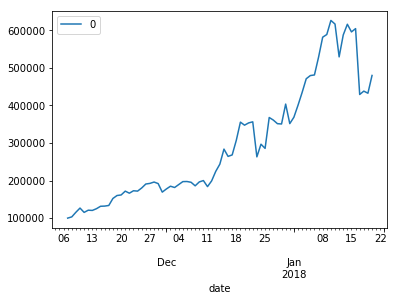

In [156]:
pd.DataFrame(wealth_history, index = price_df.index[training_days:]).plot();
# pd.DataFrame(hodl_eth.reshape(-1,1)[1:]).plot()
# pd.DataFrame(hodl_btc.reshape(-1,1)[1:]).plot();

In [66]:
hodl_btc[-1]

54871.035203903804

In [65]:
hodl_eth[-1]

53864.032539221393

# Test On All Available Coins

In [84]:
ons = ONS()
ons = ons.run(scaled_prices)

In [85]:
print(ons.summary())

Summary:
    Profit factor: 2.04
    Sharpe ratio: 3.69
    Information ratio (wrt UCRP): 1.51
    Annualized return: 40704027491.26%
    Annualized volatility: 823.96%
    Longest drawdown: 13 days
    Max drawdown: 61.20%
    Winning days: 60.2%
        


In [88]:
#ons.plot(weights = True, figsize = (15, 10));

# Test ONS On All Coin Combos

In [101]:
all_coins = {
    
    0: 'USDT_BTG',
    1: 'USDT_EDO',
    2: 'USDT_QTUM',
    3: 'USDT_AVT',
    4: 'USDT_NEO',
    5: 'USDT_BCH',
    6: 'USDT_OMG',
    7: 'USDT_SAN',
    8: 'USDT_EOS',
    9: 'USDT_IOTA',
    10: 'USDT_ZEC',
    11: 'USDT_ETC',
    12: 'USDT_ETH',
    13: 'USDT_XRP',
    14: 'USDT_BTC',
    15: 'USDT_DASH',
    16: 'USDT_XMR',
    17: 'USDT_LTC'
    
}

# create a range for iteration
iter_coins = np.arange(len(all_coins))

subsets = []

iter_coins_sum = int(len(iter_coins))
iter_coins_list = list(iter_coins)

for L in range(0, len(all_coins) + 1):
    print('starting iteration:', L)
    for subset in combinations(iter_coins_list, L):
        subsets.append(subset)

# get rid of first item (empty)
subsets = list(subsets[1:])

print('\nThere are %s possible combos total!' % len(subsets))

all_coin_combos = []

for s in subsets:
    combo = []
    for ss in s:
        combo.append(all_coins[ss])
    all_coin_combos.append(combo)

all_coin_combos = [c for c in all_coin_combos if len(c) >= 3]

print("But we're only using %s combos" % len(all_coin_combos))

starting iteration: 0
starting iteration: 1
starting iteration: 2
starting iteration: 3
starting iteration: 4
starting iteration: 5
starting iteration: 6
starting iteration: 7
starting iteration: 8
starting iteration: 9
starting iteration: 10
starting iteration: 11
starting iteration: 12
starting iteration: 13
starting iteration: 14
starting iteration: 15
starting iteration: 16
starting iteration: 17
starting iteration: 18

There are 262143 possible combos total!
But we're only using 261972 combos


In [102]:
all_results = []

for combo in tqdm_notebook(all_coin_combos):
    
    r = {}
    
    combo = [col.lower().replace('_', '') + '_close' for col in combo]
    
    ons = ONS()
    ons = ons.run(scaled_prices[combo])
    
    r['coin_combo'] = str(combo)
    r['profit'] = ons.profit_factor
    r['sharpe'] = ons.sharpe
    r['return'] = ons.annualized_return
    r['max_drawdown'] = ons.max_drawdown
    
    all_results.append(r)
    
    # replaced with tqdm
    #if len(all_results) % 1000 == 0: print(len(all_results))

# Latest

In [127]:
results_df = pd.DataFrame(all_results).sort_values('return', ascending = False).reset_index(drop = True)

In [144]:
results_df.sort_values('sharpe', ascending = False)[:10]

,coin_combo,max_drawdown,profit,return,sharpe
30392,"['usdtbch_close', 'usdteos_close', 'usdtzec_cl...",0.378269,4.066995,2.705494e+08,7.270668
77428,"['usdtbch_close', 'usdteos_close', 'usdtzec_cl...",0.384219,3.761553,3.814458e+07,6.917587
109790,"['usdtbch_close', 'usdteos_close', 'usdtbtc_cl...",0.376486,3.541018,1.217596e+07,6.831110
47261,"['usdteos_close', 'usdtzec_close', 'usdtbtc_cl...",0.385138,3.388084,1.270854e+08,6.307854
29011,"['usdtbch_close', 'usdtzec_close', 'usdtbtc_cl...",0.475349,3.261049,2.889854e+08,6.110164
66,"['usdtbtg_close', 'usdtedo_close', 'usdtneo_cl...",0.438689,3.326817,3.632608e+10,6.052467
70,"['usdtbtg_close', 'usdtedo_close', 'usdtneo_cl...",0.438563,3.324047,3.586362e+10,6.052055
74,"['usdtbtg_close', 'usdtedo_close', 'usdtneo_cl...",0.438470,3.321799,3.550289e+10,6.051733
79,"['usdtbtg_close', 'usdtedo_close', 'usdtneo_cl...",0.438358,3.318145,3.492200e+10,6.050968
76,"['usdtbtg_close', 'usdtedo_close', 'usdtneo_cl...",0.439131,3.325206,3.538206e+10,6.046619


### HIGHEST RETURN:

1) ['usdtbtg_close', 'usdtedo_close', 'usdtsan_close', 'usdtzec_close', 'usdtetc_close', 'usdtxrp_close', 'usdtbtc_close', 'usdtxmr_close']

2) ['usdtbtg_close', 'usdtedo_close', 'usdtbch_close', 'usdtsan_close', 'usdtzec_close', 'usdtetc_close', 'usdtxrp_close', 'usdtbtc_close', 'usdtxmr_close']

3) ['usdtbtg_close', 'usdtedo_close', 'usdtbch_close', 'usdtsan_close', 'usdtiota_close', 'usdtzec_close', 'usdtetc_close', 'usdtxrp_close', 'usdtbtc_close', 'usdtxmr_close']

4) ['usdtbtg_close', 'usdtedo_close', 'usdtsan_close', 'usdtiota_close', 'usdtzec_close', 'usdtetc_close', 'usdtxrp_close', 'usdtbtc_close', 'usdtxmr_close']

5) ['usdtbtg_close', 'usdtedo_close', 'usdtbch_close', 'usdtsan_close', 'usdtzec_close', 'usdtetc_close', 'usdtxrp_close', 'usdtbtc_close', 'usdtxmr_close', 'usdtltc_close']

6) ['usdtbtg_close', 'usdtedo_close', 'usdtsan_close', 'usdtzec_close', 'usdtetc_close', 'usdtxrp_close', 'usdtbtc_close', 'usdtxmr_close', 'usdtltc_close']

7) ['usdtbtg_close', 'usdtedo_close', 'usdtbch_close', 'usdtsan_close', 'usdtiota_close', 'usdtzec_close', 'usdtetc_close', 'usdtxrp_close', 'usdtbtc_close', 'usdtxmr_close', 'usdtltc_close']

8) ['usdtbtg_close', 'usdtedo_close', 'usdtsan_close', 'usdtiota_close', 'usdtzec_close', 'usdtetc_close', 'usdtxrp_close', 'usdtbtc_close', 'usdtxmr_close', 'usdtltc_close']

9) ['usdtbtg_close', 'usdtedo_close', 'usdtiota_close', 'usdtzec_close', 'usdtetc_close', 'usdtxrp_close', 'usdtbtc_close', 'usdtxmr_close']

10) ['usdtbtg_close', 'usdtedo_close', 'usdtbch_close', 'usdtiota_close', 'usdtzec_close', 'usdtetc_close', 'usdtxrp_close', 'usdtbtc_close', 'usdtxmr_close']

### HIGHEST SHARPE

1) ['usdtbch_close', 'usdteos_close', 'usdtzec_close', 'usdtbtc_close']

2) ['usdtbch_close', 'usdteos_close', 'usdtzec_close']

3) ['usdtbch_close', 'usdteos_close', 'usdtbtc_close']

4) ['usdteos_close', 'usdtzec_close', 'usdtbtc_close']

5) ['usdtbch_close', 'usdtzec_close', 'usdtbtc_close']

6) ['usdtbtg_close', 'usdtedo_close', 'usdtneo_close', 'usdtbch_close', 'usdtsan_close', 'usdteos_close', 'usdtiota_close', 'usdtzec_close', 'usdtetc_close', 'usdteth_close', 'usdtxrp_close', 'usdtbtc_close', 'usdtdash_close', 'usdtxmr_close', 'usdtltc_close']

7) ['usdtbtg_close', 'usdtedo_close', 'usdtneo_close', 'usdtbch_close', 'usdtsan_close', 'usdteos_close', 'usdtiota_close', 'usdtetc_close', 'usdteth_close', 'usdtxrp_close', 'usdtbtc_close', 'usdtdash_close', 'usdtxmr_close', 'usdtltc_close']

8) ['usdtbtg_close', 'usdtedo_close', 'usdtneo_close', 'usdtsan_close', 'usdteos_close', 'usdtiota_close', 'usdtzec_close', 'usdtetc_close', 'usdteth_close', 'usdtxrp_close', 'usdtbtc_close', 'usdtdash_close', 'usdtxmr_close', 'usdtltc_close']

9) ['usdtbtg_close', 'usdtedo_close', 'usdtneo_close', 'usdtsan_close', 'usdteos_close', 'usdtiota_close', 'usdtetc_close', 'usdteth_close', 'usdtxrp_close', 'usdtbtc_close', 'usdtdash_close', 'usdtxmr_close', 'usdtltc_close']

10) ['usdtbtg_close', 'usdtedo_close', 'usdtneo_close', 'usdtsan_close', 'usdtiota_close', 'usdtzec_close', 'usdtetc_close', 'usdteth_close', 'usdtxrp_close', 'usdtbtc_close', 'usdtdash_close', 'usdtxmr_close', 'usdtltc_close']

In [156]:
results_df.loc[76].coin_combo

"['usdtbtg_close', 'usdtedo_close', 'usdtneo_close', 'usdtsan_close', 'usdtiota_close', 'usdtzec_close', 'usdtetc_close', 'usdteth_close', 'usdtxrp_close', 'usdtbtc_close', 'usdtdash_close', 'usdtxmr_close', 'usdtltc_close']"

# Using My Trading Simulation

In [66]:
model_sim = pd.read_csv('ons_portfolio_finder_export_2018-01-21.csv')
model_sim = model_sim.drop('Unnamed: 0', 1)

print('Number of combos:', model_sim.shape[0])

Number of combos: 261972


In [67]:
top_return = model_sim.iloc[:10000,:].coin_combo.tolist()
top_sharpe = model_sim.sort_values('sharpe', ascending = False).reset_index(drop = True).iloc[:10000,:].coin_combo.tolist()

top_combos = list(set(top_return + top_sharpe))

print('Number of Combos:', len(top_combos))

Number of Combos: 15245


In [13]:
# from random import choice
# s = [choice(top_combos) for i in range(10)]

In [68]:
all_results_manual = []

#for combo in tqdm_notebook(top_combos):
for combo in tqdm_notebook(top_combos):
    
    r = {}
    
    combo = eval(combo)
    
    sim_results = trading_simulation(scaled_prices[combo].copy(),
                                     init_capital = 100000,
                                     train_window = 14,
                                     trading_fee = 0.0025,
                                     progress_print = 250
                                    )
    
    sim_performance = performance_summary(sim_results)
    
    r['coin_combo'] = str(combo)
    r['return'] = float(sim_performance[0])
    r['sharpe'] = float(sim_performance[1])
    
    #print(sim_performance)
    
    all_results_manual.append(r)
    
    # free memory
    del sim_results, sim_performance

/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:101: FutureWarning: pd.expanding_max is deprecated for Series and will be removed in a future version, replace with 
	Series.expanding(min_periods=1).max()


In [70]:
# custom_sim_portfolio_perf = pd.DataFrame(all_results_manual)
# custom_sim_portfolio_perf.to_csv('ons_portfolio_finder_export_CUSTOMSIM_2018-01-23.csv')

In [73]:
custom_sim_portfolio_perf.sort_values('sharpe', ascending = False).head()

,coin_combo,return,sharpe
13315,"['usdtbch_close', 'usdteos_close', 'usdtbtc_cl...",33.404556,0.936932
13124,"['usdtbch_close', 'usdteos_close', 'usdtzec_cl...",46.024094,0.933064
4734,"['usdtbch_close', 'usdteos_close', 'usdtzec_cl...",36.165637,0.911083
13125,"['usdteos_close', 'usdtzec_close', 'usdtbtc_cl...",39.631235,0.874999
3772,"['usdtsan_close', 'usdtzec_close', 'usdtxmr_cl...",59.194627,0.848855


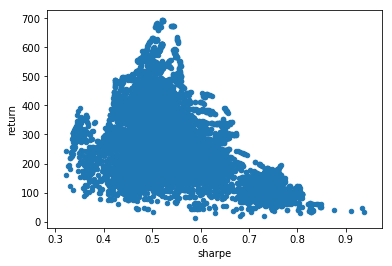

In [76]:
custom_sim_portfolio_perf.plot('sharpe', 'return', kind = 'scatter')

In [81]:
custom_sim_portfolio_perf[(custom_sim_portfolio_perf['sharpe'] >= 0.6) & (custom_sim_portfolio_perf['return'] >= 400)]

,coin_combo,return,sharpe
1229,"['usdtbtg_close', 'usdtedo_close', 'usdtneo_cl...",437.818893,0.614020
1563,"['usdtbtg_close', 'usdtedo_close', 'usdtneo_cl...",441.372336,0.603644
2567,"['usdtbtg_close', 'usdtedo_close', 'usdtneo_cl...",434.881796,0.620205
2642,"['usdtbtg_close', 'usdtedo_close', 'usdtneo_cl...",438.674062,0.611933
6675,"['usdtbtg_close', 'usdtedo_close', 'usdtneo_cl...",431.229106,0.605986
6990,"['usdtbtg_close', 'usdtedo_close', 'usdtneo_cl...",436.504285,0.616311
7324,"['usdtbtg_close', 'usdtedo_close', 'usdtneo_cl...",432.634348,0.604564
7415,"['usdtbtg_close', 'usdtedo_close', 'usdtneo_cl...",440.703257,0.604867
7454,"['usdtbtg_close', 'usdtedo_close', 'usdtneo_cl...",432.764864,0.622868
7536,"['usdtbtg_close', 'usdtedo_close', 'usdtneo_cl...",431.452004,0.605548


In [90]:
scaler = StandardScaler()

norm_results = custom_sim_portfolio_perf.copy()

# norm_results['return'] = scaler.fit_transform(custom_sim_portfolio_perf['return']).copy()
# norm_results['sharpe'] = scaler.fit_transform(custom_sim_portfolio_perf['sharpe']).copy()

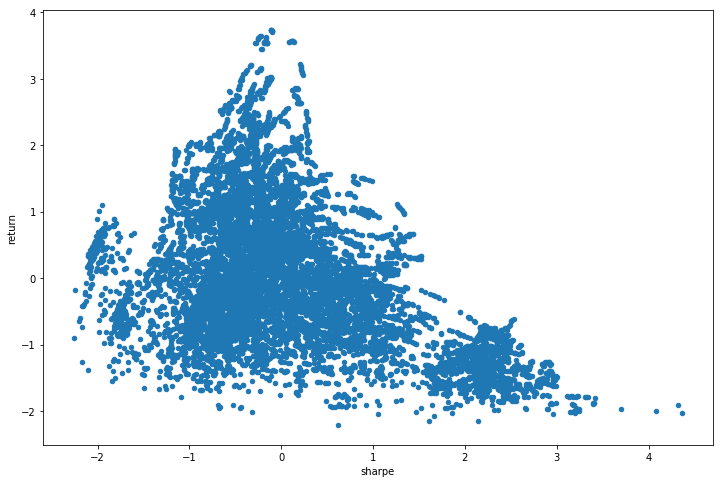

In [97]:
norm_results.plot('sharpe', 'return', kind = 'scatter', figsize = ((12, 8)));

In [99]:
high_return_low_risk = norm_results[(norm_results['sharpe'] >= 1) & (norm_results['return'] >= 1)]

In [101]:
high_return_low_risk['score'] = high_return_low_risk['return'] + high_return_low_risk['sharpe']

/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [104]:
high_return_low_risk = high_return_low_risk.sort_values('score', ascending = False).reset_index(drop = True)

In [124]:
high_return_low_risk

,coin_combo,return,sharpe,score
0,"['usdtbtg_close', 'usdtedo_close', 'usdtneo_cl...",1.111427,1.262391,2.373818
1,"['usdtbtg_close', 'usdtedo_close', 'usdtneo_cl...",1.087039,1.275478,2.362517
2,"['usdtbtg_close', 'usdtedo_close', 'usdtneo_cl...",1.068785,1.285056,2.353841
3,"['usdtbtg_close', 'usdtedo_close', 'usdtneo_cl...",1.049772,1.295161,2.344933
4,"['usdtbtg_close', 'usdtedo_close', 'usdtneo_cl...",1.018655,1.311352,2.330007


# Results

## Return >= 1, Sharpe >= 1

1) ['usdtbtg_close', 'usdtedo_close', 'usdtneo_close', 'usdtsan_close', 'usdteos_close', 'usdtiota_close', 'usdtetc_close', 'usdteth_close', 'usdtbtc_close', 'usdtdash_close', 'usdtxmr_close', 'usdtltc_close']

2) ['usdtbtg_close', 'usdtedo_close', 'usdtneo_close', 'usdtsan_close', 'usdteos_close', 'usdtiota_close', 'usdtzec_close', 'usdtetc_close', 'usdteth_close', 'usdtbtc_close', 'usdtdash_close', 'usdtxmr_close', 'usdtltc_close']

3) ['usdtbtg_close', 'usdtedo_close', 'usdtneo_close', 'usdtbch_close', 'usdtsan_close', 'usdteos_close', 'usdtiota_close', 'usdtetc_close', 'usdteth_close', 'usdtbtc_close', 'usdtdash_close', 'usdtxmr_close', 'usdtltc_close']

4) ['usdtbtg_close', 'usdtedo_close', 'usdtneo_close', 'usdtbch_close', 'usdtsan_close', 'usdteos_close', 'usdtiota_close', 'usdtzec_close', 'usdtetc_close', 'usdteth_close', 'usdtbtc_close', 'usdtdash_close', 'usdtxmr_close', 'usdtltc_close']

5) ['usdtbtg_close', 'usdtedo_close', 'usdtneo_close', 'usdtsan_close', 'usdtiota_close', 'usdtetc_close', 'usdteth_close', 'usdtbtc_close', 'usdtdash_close', 'usdtxmr_close', 'usdtltc_close']


## Top Returns

1) ['usdtbtg_close', 'usdtedo_close', 'usdtneo_close', 'usdtsan_close', 'usdteos_close', 'usdtiota_close', 'usdteth_close', 'usdtxrp_close', 'usdtbtc_close', 'usdtdash_close', 'usdtxmr_close', 'usdtltc_close']

2) ['usdtbtg_close', 'usdtedo_close', 'usdtneo_close', 'usdtsan_close', 'usdteos_close', 'usdtiota_close', 'usdtzec_close', 'usdteth_close', 'usdtxrp_close', 'usdtbtc_close', 'usdtdash_close', 'usdtxmr_close', 'usdtltc_close']

3) ['usdtbtg_close', 'usdtedo_close', 'usdtneo_close', 'usdtbch_close', 'usdtsan_close', 'usdteos_close', 'usdtiota_close', 'usdteth_close', 'usdtxrp_close', 'usdtbtc_close', 'usdtdash_close', 'usdtxmr_close', 'usdtltc_close']

4) ['usdtbtg_close', 'usdtedo_close', 'usdtneo_close', 'usdtbch_close', 'usdtsan_close', 'usdteos_close', 'usdtiota_close', 'usdtzec_close', 'usdteth_close', 'usdtxrp_close', 'usdtbtc_close', 'usdtdash_close', 'usdtxmr_close', 'usdtltc_close']

5) ['usdtbtg_close', 'usdtedo_close', 'usdtneo_close', 'usdtsan_close', 'usdtiota_close', 'usdteth_close', 'usdtxrp_close', 'usdtbtc_close', 'usdtdash_close', 'usdtxmr_close', 'usdtltc_close']

In [126]:
high_returns_only = norm_results.sort_values('return', ascending = False).reset_index(drop = True)